In [920]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,RobustScaler
from sklearn.linear_model import Ridge,LinearRegression,Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,learning_curve, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
import pickle

In [921]:
df = pd.read_csv("dataset_clear.csv")

In [922]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [923]:
feature = df.columns[0:-1]
target = 'charges'
X =df.drop(["charges"],axis=1)
y = df[target]



In [924]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 62.8+ KB


In [925]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, random_state=42, train_size = 0.8)

In [926]:
dummy = DummyRegressor()

In [927]:
numerical_features = [
       'age','bmi','children'
       ]
categorical_features = [
       'sex' , 'smoker', 'region'
       ]



In [928]:


my_col_trans = ColumnTransformer([
    ("sclal",StandardScaler(),numerical_features),
    
    ("one_hot_encoder",OneHotEncoder(handle_unknown='ignore'),categorical_features),
    
])



In [929]:
X_train.head()

,age,sex,bmi,children,smoker,region
1113,23,male,24.510,0,no,northeast
967,21,male,25.745,2,no,northeast
598,52,female,37.525,2,no,northwest
170,63,male,41.470,0,no,southeast
275,47,female,26.600,2,no,northeast


In [930]:
dummy.fit(X_train,y_train)
dummy.score(X_train,y_train)

0.0

In [931]:
dummy.score(X_test,y_test)

-0.008391982350864469

In [932]:
# modelLasso= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), Lasso(max_iter=100000,random_state=42))
# parameters = {"lasso__alpha":np.linspace(0.1,100,1000)}
# randm_src = GridSearchCV(estimator=modelLasso, param_grid=parameters,scoring='r2')
# randm_src.fit(X_train, y_train)


# modelLasso.set_params(**randm_src.best_params_)
# print(randm_src.best_params_)
# best=randm_src.best_params_

In [933]:
# best["lasso__alpha"]
best=52.50000000000001

In [934]:
modelLasso= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), Lasso(alpha=best,max_iter=100000,random_state=42))
modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)


0.8314249301318716

In [935]:
modelLasso.score(X_test,y_test)

0.8847366451214002

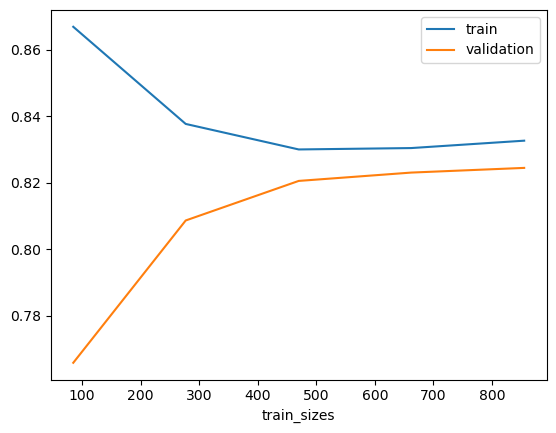

In [936]:
train_sizes, train_scores, test_scores = learning_curve(modelLasso,X_train,y_train)                                         
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [937]:
y_pred = modelLasso.predict(X_train)

In [938]:
residual = (y_pred - y_train).abs().sort_values()

In [939]:
residual.describe()

count     1069.000000
mean      2952.651900
std       3791.529327
min          2.906933
25%       1298.592725
50%       1713.268257
75%       2263.300977
max      30744.607492
Name: charges, dtype: float64

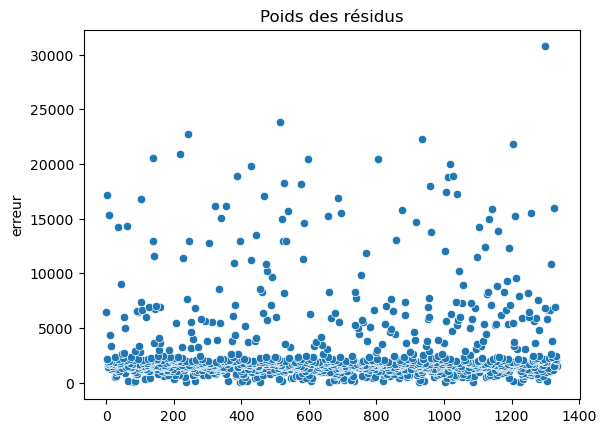

In [940]:


sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()



In [941]:
residual.quantile(0.90)

6726.460224941315

In [942]:
to_drop = residual[residual > residual.quantile(0.90)].index

In [943]:
X_train.loc[to_drop]



,age,sex,bmi,children,smoker,region
1300,62,male,30.875,3,yes,northwest
264,53,female,38.060,3,no,southeast
1092,22,female,30.400,0,yes,northwest
126,19,female,28.300,0,yes,southwest
159,50,female,27.830,3,no,southeast
...,...,...,...,...,...,...
1205,59,female,34.800,2,no,southwest
935,44,male,29.735,2,no,northeast
242,55,female,26.800,1,no,southwest
516,20,male,35.310,1,no,southeast


In [944]:
to_drop=X_train.loc[to_drop][X_train.loc[to_drop]["smoker"]== "no"].index

In [945]:


X_train = X_train.drop(to_drop)
y_train = y_train.drop(to_drop)



In [946]:


modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)



0.9503314624642754

In [947]:


modelLasso.score(X_test,y_test)



0.881417730211737

In [948]:
y_pred = modelLasso.predict(X_train)

In [949]:
residual = (y_pred - y_train).abs().sort_values()

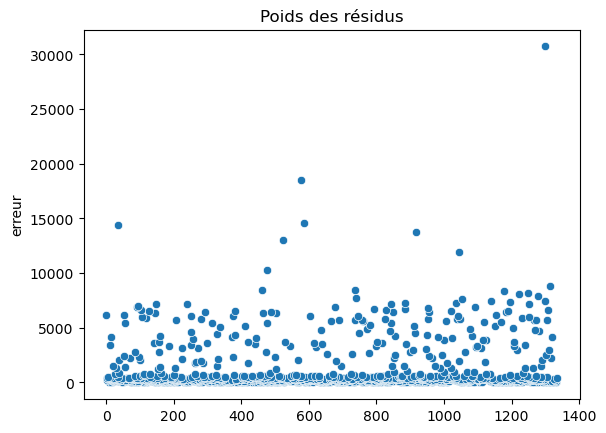

In [950]:
sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

In [951]:
residual.describe()

count      993.000000
mean      1175.876585
std       2328.041801
min          0.625595
25%        150.206644
50%        328.685242
75%        589.360301
max      30730.089172
Name: charges, dtype: float64

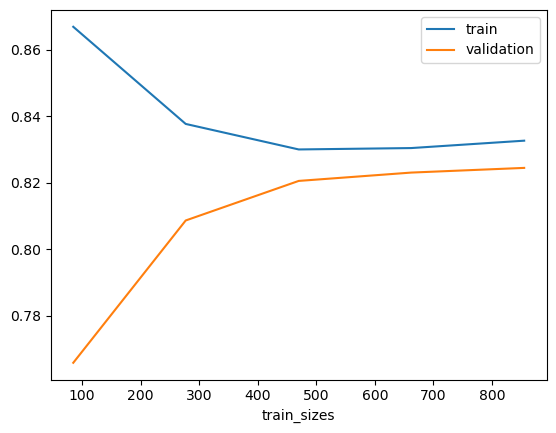

In [952]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [953]:
y_pred = modelLasso.predict(X_train)
residual = (y_pred - y_train).abs().sort_values()
to_drop = residual[residual > 5000].index


In [954]:
X_train.loc[to_drop]

,age,sex,bmi,children,smoker,region
338,50,male,32.300,1,yes,northeast
412,26,female,17.195,2,yes,northeast
1151,43,female,32.560,3,yes,southeast
910,18,male,31.730,0,yes,northeast
782,50,female,27.600,1,yes,southwest
...,...,...,...,...,...,...
916,45,male,22.895,0,yes,northeast
34,28,male,36.400,1,yes,southwest
586,34,female,30.210,1,yes,northwest
577,31,female,38.095,1,yes,northeast


In [955]:
to_drop=X_train.loc[to_drop][X_train.loc[to_drop]["smoker"]== "no"].index

In [956]:
X_train = X_train.drop(to_drop)
y_train = y_train.drop(to_drop)

In [957]:

modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)

0.9518834534190656

In [958]:
modelLasso.score(X_test,y_test)

0.8810312869605681

In [959]:
y_pred = modelLasso.predict(X_train)
residual = (y_pred - y_train).abs().sort_values()

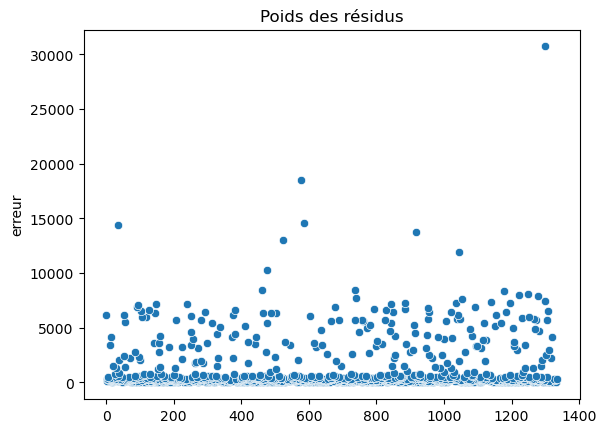

In [960]:
sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

In [961]:
residual.describe()

count      989.000000
mean      1140.743294
std       2305.330715
min          0.057448
25%        127.592126
50%        296.332291
75%        564.108132
max      30719.415149
Name: charges, dtype: float64

In [962]:
residual.sort_values(ascending=False)

1299    30719.415149
577     18493.328246
586     14599.296408
34      14422.142666
916     13797.811139
            ...     
527         2.842986
399         2.173348
183         0.548725
110         0.117068
90          0.057448
Name: charges, Length: 989, dtype: float64

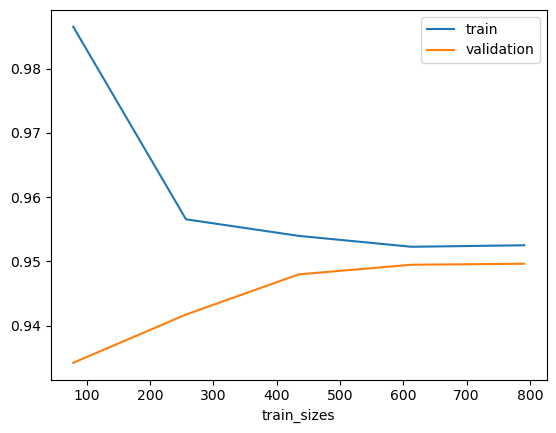

In [963]:
train_sizes, train_scores, test_scores = learning_curve(modelLasso,X_train,y_train)                                         
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [964]:
pickle_out = open("modelLasso.pkl", "wb") 
pickle.dump(modelLasso, pickle_out) 
pickle_out.close()